In [21]:
!pip install pandas
!pip install matplotlib
!pip install scikit-learn
!pip install seaborn

In [195]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from scipy import stats


In [196]:
df1 = pd.read_csv('bitcoin_data_history1.csv')
df2 = pd.read_csv('bitcoin_data_history2.csv',on_bad_lines='skip')

df1.columns = df1.columns.str.strip()
df2.columns = df2.columns.str.strip()

df2 = df2.drop(columns=[col for col in df2.columns if 'Unnamed' in col or col == ''])


In [197]:
import pandas as pd
import numpy as np

for col in df1.columns:
    if df1[col].dtype == 'int64':
        df2[col] = pd.to_numeric(df2[col], errors='coerce').fillna(0).astype(int)
    elif df1[col].dtype == 'float64':
        df2[col] = pd.to_numeric(df2[col], errors='coerce')  # Coerce invalid values to NaN
    else:
        df2[col] = df2[col].astype(df1[col].dtype)  # For any other type (shouldn't be in this case)



In [198]:

df_merged = pd.concat([df1, df2], axis=0).reset_index(drop=True)
print(df_merged.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 47933 entries, 0 to 47932
Data columns (total 22 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   timestamp              47933 non-null  int64  
 1   block_height           47933 non-null  int64  
 2   tx_count               47933 non-null  int64  
 3   mempool_size_mb        47932 non-null  float64
 4   min_fee_rate           47933 non-null  float64
 5   max_fee_rate           47933 non-null  float64
 6   avg_fee_rate           47933 non-null  float64
 7   median_fee_rate        47932 non-null  float64
 8   fee_rate_10th          47932 non-null  float64
 9   fee_rate_90th          47932 non-null  float64
 10  fee_rate_std           47932 non-null  float64
 11  block_time             47933 non-null  int64  
 12  difficulty             47932 non-null  float64
 13  hash_rate              47932 non-null  float64
 14  mempool_min_fee        47932 non-null  float64
 15  to

In [199]:
df=df_merged

In [200]:
# Convert 'block_time' to datetime
df['block_time'] = pd.to_datetime(df['block_time'], unit='s')

# Set 'block_time' as index
df.set_index('block_time', inplace=True)

In [201]:

def plot_boxplots(df, title):
    n_cols = len(df.columns)
    n_rows = (n_cols + 3) // 4  
    
    plt.figure(figsize=(20, 5 * n_rows))
    for i, column in enumerate(df.columns):
        plt.subplot(n_rows, 4, i+1)
        sns.boxplot(y=df[column])
        plt.title(column)
    plt.suptitle(title, fontsize=16)
    plt.tight_layout()
    plt.show()




Original data shape: (47933, 21)
Removed 0 duplicate rows.

Columns with NaN values:
mempool_size_mb            1
median_fee_rate            1
fee_rate_10th              1
fee_rate_90th              1
fee_rate_std               1
difficulty                 1
hash_rate                  1
mempool_min_fee            1
total_fee                  1
block_interval             4
block_median_fee_rate    145
dtype: int64
No NaN values found after handling.


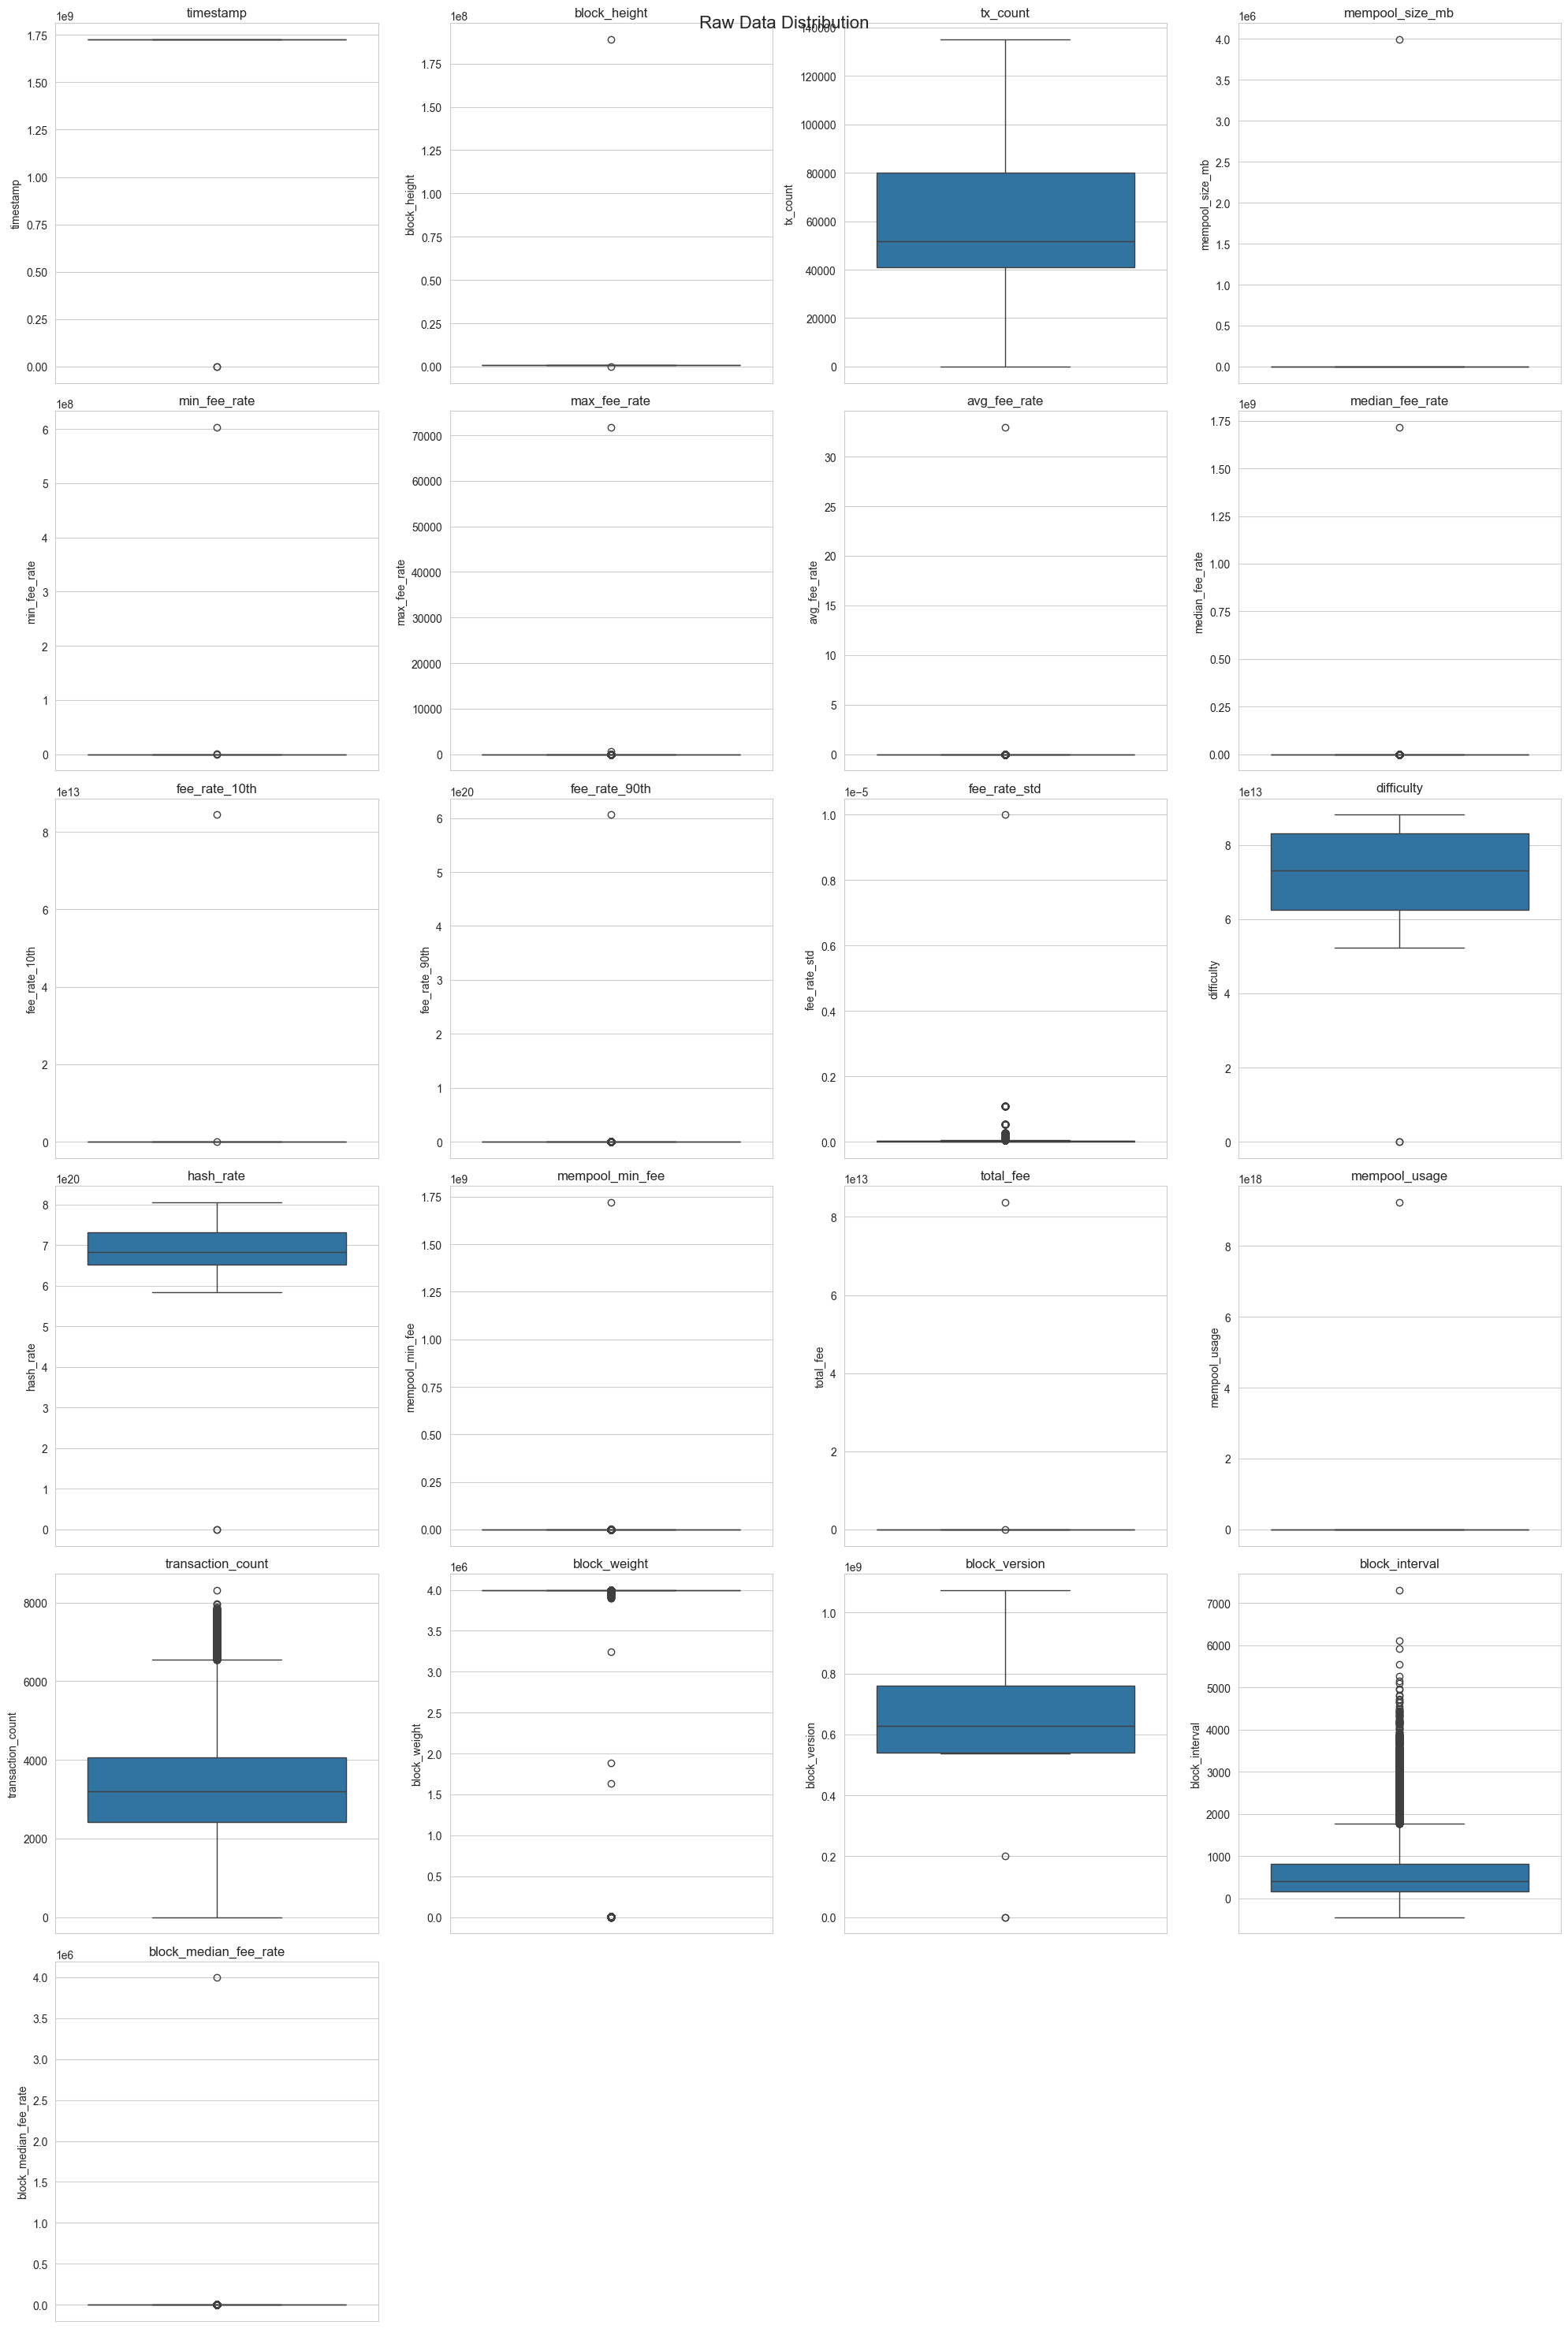

In [202]:
print("Original data shape:", df.shape)

duplicates = df.duplicated().sum()
df = df.drop_duplicates()
print(f"Removed {duplicates} duplicate rows.")

nan_counts = df.isna().sum()
columns_with_nan = nan_counts[nan_counts > 0]
if not columns_with_nan.empty:
    print("\nColumns with NaN values:")
    print(columns_with_nan)
    
    # Handle NaN values
    median_interval = df['block_interval'].median()  # Calculate median interval once
    for column in columns_with_nan.index:
        if column == 'block_interval':
            # For the first row, use the median interval. For others, forward fill.
            df['block_interval'] = df['block_interval'].ffill().fillna(median_interval)
        elif column == 'block_median_fee_rate':
            # Use forward fill, then backward fill for any remaining NaNs
            df[column] = df[column].ffill().bfill()
        elif column in ['mempool_size_mb', 'tx_count', 'mempool_usage']:
            # For mempool-related metrics, 0 might be appropriate if the mempool was empty
            df[column] = df[column].fillna(0)
        else:
            # For other columns, use forward fill, then backward fill
            df[column] = df[column].ffill().bfill()

    remaining_nans = df.isna().sum()[df.isna().sum() > 0]
    if not remaining_nans.empty:
        print("\nRemaining NaN values after handling:")
        print(remaining_nans)
    else:
        print("No NaN values found after handling.")
else:
    print("No NaN values found.")

# If there are still any NaN values, drop those rows
rows_before = df.shape[0]
df = df.dropna()
rows_after = df.shape[0]
if rows_before > rows_after:
    print(f"\nDropped {rows_before - rows_after} rows with remaining NaN values.")


if df.empty:
    print("Warning: DataFrame is empty after cleaning. Please check the data processing steps.")
else:
    # Plotting the distribution of the cleaned data
    plot_boxplots(df, "Raw Data Distribution")


In [203]:
# Calculate the difference between consecutive block_height values to find any anomalies
df['block_height_diff'] = df['block_height'].diff()

# Look for large jumps in block_height (should typically be 1)
anomalies = df[df['block_height_diff'] > 1]
print(f"Found {len(anomalies)} anomalies in block_height increments:")
print(anomalies[['block_height', 'block_height_diff']])


Found 4 anomalies in block_height increments:
                     block_height  block_height_diff
block_time                                          
2024-07-23 18:10:47        853599             8869.0
2024-05-24 20:20:58        844971           844971.0
2024-06-30 11:38:46        850099             5097.0
1970-01-01 00:00:00     188893824        188040227.0


In [204]:
# Remove the row with the extreme block_height outlier

# Manually filter out the problematic block_height values
df_cleaned = df[(df['block_height'] != 188893824) & 
                (df['block_height'] != 853599) & 
                (df['block_height'] != 844971) & 
                (df['block_height'] != 850099)]


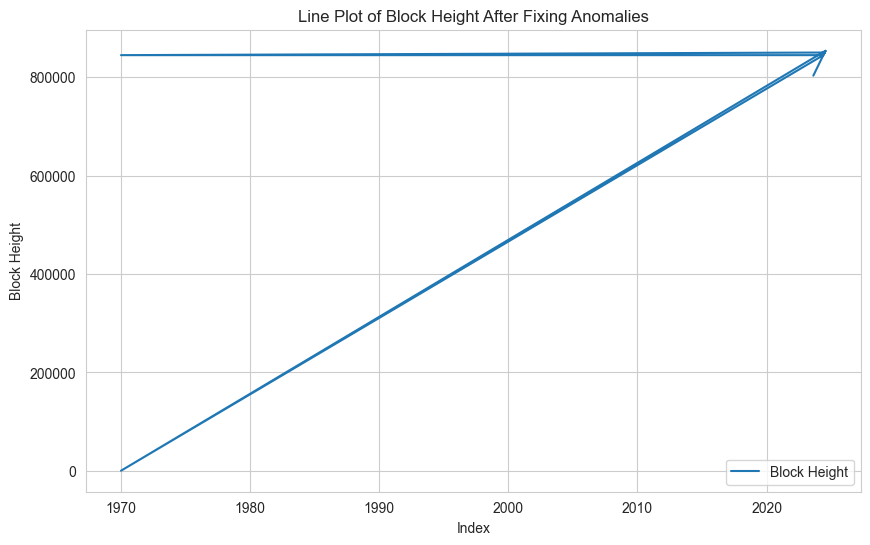

In [205]:
# Visualize the cleaned block_height
plt.figure(figsize=(10, 6))
plt.plot(df_cleaned['block_height'], label='Block Height')
plt.title("Line Plot of Block Height After Fixing Anomalies")
plt.xlabel("Index")
plt.ylabel("Block Height")
plt.legend()
plt.show()



In [206]:
# Check the minimum and maximum dates
print("Min block_time:", df_cleaned.index.min())
print("Max block_time:", df_cleaned.index.max())

# Check how many rows have '1970-01-01' as the block_time
invalid_dates = df_cleaned[df_cleaned.index == '1970-01-01']
print(f"Found {len(invalid_dates)} rows with the invalid date '1970-01-01'")


Min block_time: 1970-01-01 00:00:00
Max block_time: 2024-07-26 07:21:06
Found 2 rows with the invalid date '1970-01-01'


In [207]:
# Remove rows with invalid block_time
df_cleaned = df_cleaned[df_cleaned.index != '1970-01-01']


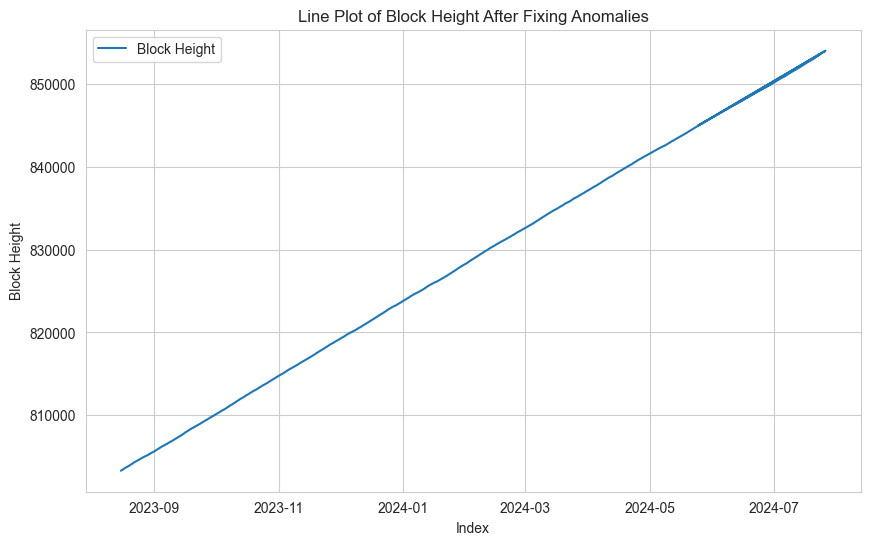

In [208]:
# Visualize the cleaned block_height
plt.figure(figsize=(10, 6))
plt.plot(df_cleaned['block_height'], label='Block Height')
plt.title("Line Plot of Block Height After Fixing Anomalies")
plt.xlabel("Index")
plt.ylabel("Block Height")
plt.legend()
plt.show()


In [209]:
# Remove duplicate block_height values and keep only the first occurrence
df_cleaned = df_cleaned.drop_duplicates(subset=['block_height'], keep='first')

# Print the shape of the DataFrame after removing duplicates
print(f"Shape of the DataFrame after removing duplicates: {df_cleaned_no_duplicates.shape}")


Shape of the DataFrame after removing duplicates: (47926, 22)


In [210]:
# Check for duplicate values in the block_height column
duplicate_block_heights = df_cleaned[df_cleaned['block_height'].duplicated(keep=False)]

# Print the duplicate block heights
print(f"Number of duplicate block heights: {len(duplicate_block_heights)}")
print(duplicate_block_heights[['block_height']])

Number of duplicate block heights: 0
Empty DataFrame
Columns: [block_height]
Index: []


In [211]:
# Check for duplicate index values
duplicate_indices = df_cleaned.index.duplicated(keep=False)

# Print the number of duplicate index values
print(f"Number of duplicate indices: {duplicate_indices.sum()}")

# Show the rows with duplicate indices
df_duplicates = df_cleaned[duplicate_indices]
print(df_duplicates)


Number of duplicate indices: 14
                      timestamp  block_height  tx_count  mempool_size_mb  \
block_time                                                                 
2023-12-24 21:24:33  1725323273        822786    116122        41.239090   
2023-12-24 21:24:33  1725323309        822788    116202        41.260115   
2024-01-31 09:12:40  1725387592        828225    127760        44.883422   
2024-01-31 09:12:40  1725387603        828226    127789        44.890101   
2024-02-23 13:52:32  1725504098        831690     53332         8.005034   
2024-02-23 13:52:32  1725504120        831691     53794         8.084864   
2024-02-26 15:58:50  1725508728        832145     53821         9.285521   
2024-02-26 15:58:50  1725508735        832146     53831         9.287004   
2024-03-25 10:42:34  1725535947        836232     31290         9.089303   
2024-03-25 10:42:34  1725535952        836233     31443         9.109860   
2024-06-15 15:16:41  1725658165        848041     64208 

In [212]:
# Drop duplicate index rows
df_cleaned = df_cleaned[~df_cleaned.index.duplicated(keep='first')]

# Recheck if duplicates remain
print(f"Number of remaining duplicate indices: {df_cleaned.index.duplicated().sum()}")


Number of remaining duplicate indices: 0


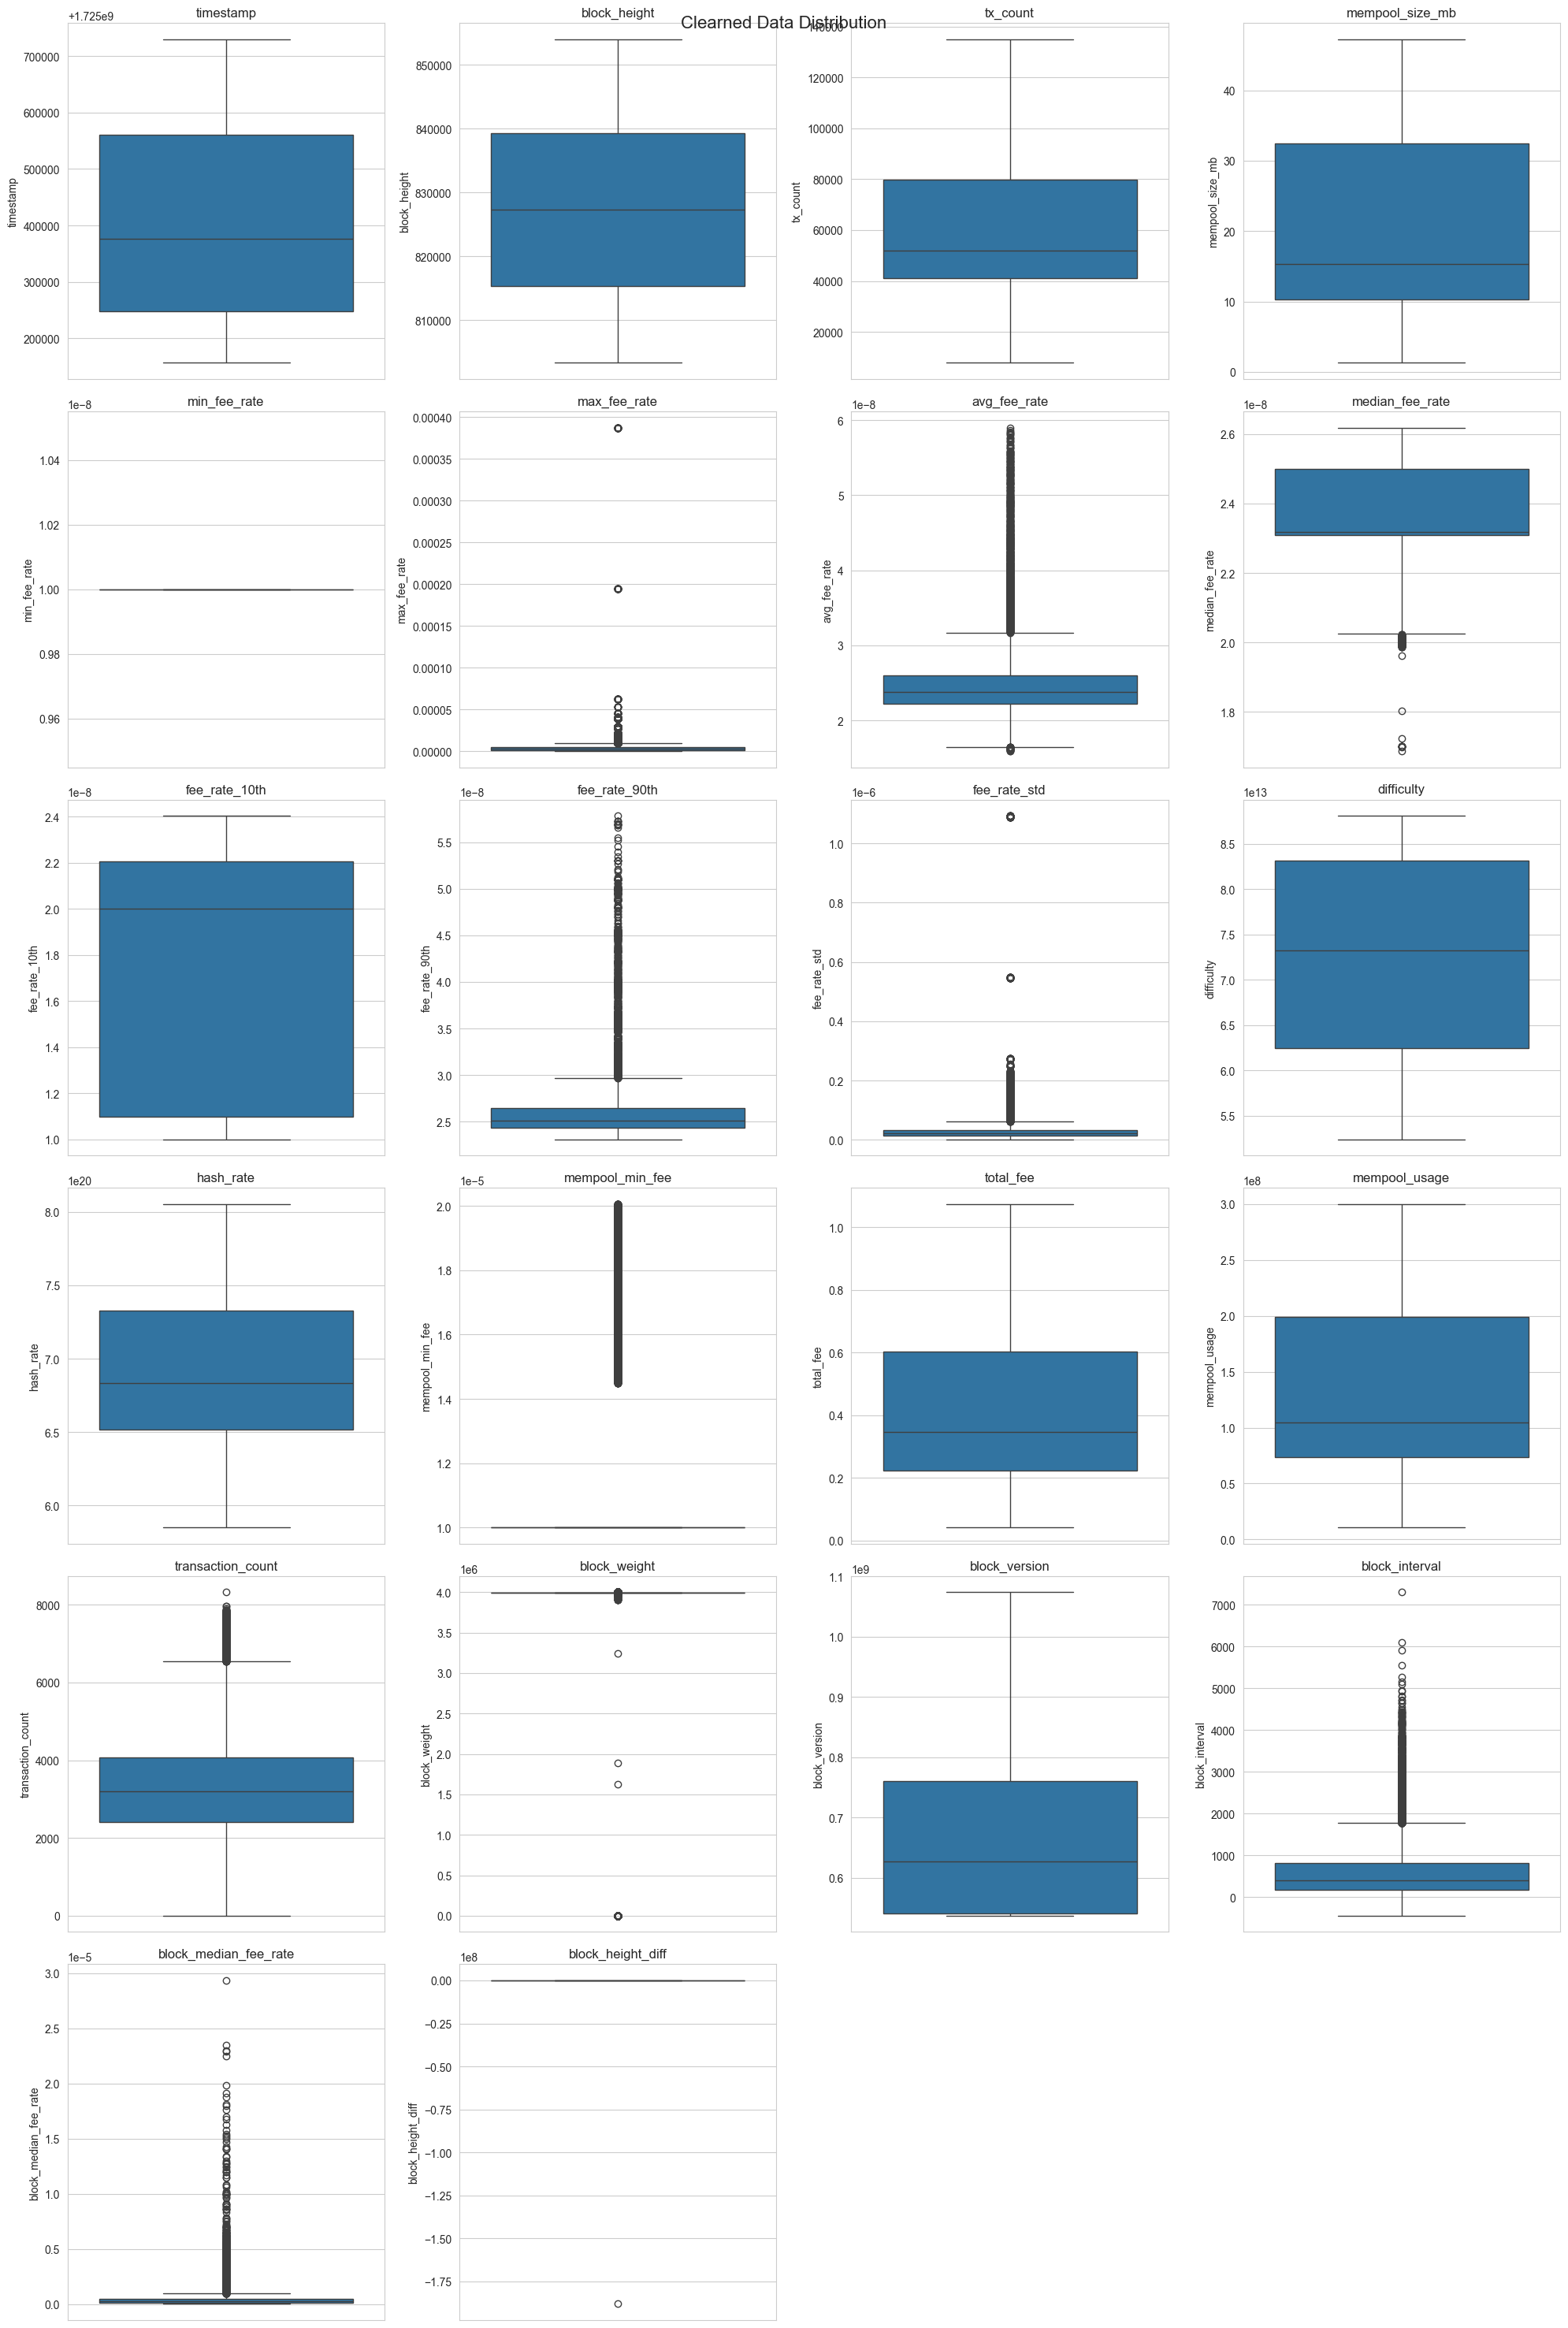

In [213]:

plot_boxplots(df_cleaned, "Clearned Data Distribution")

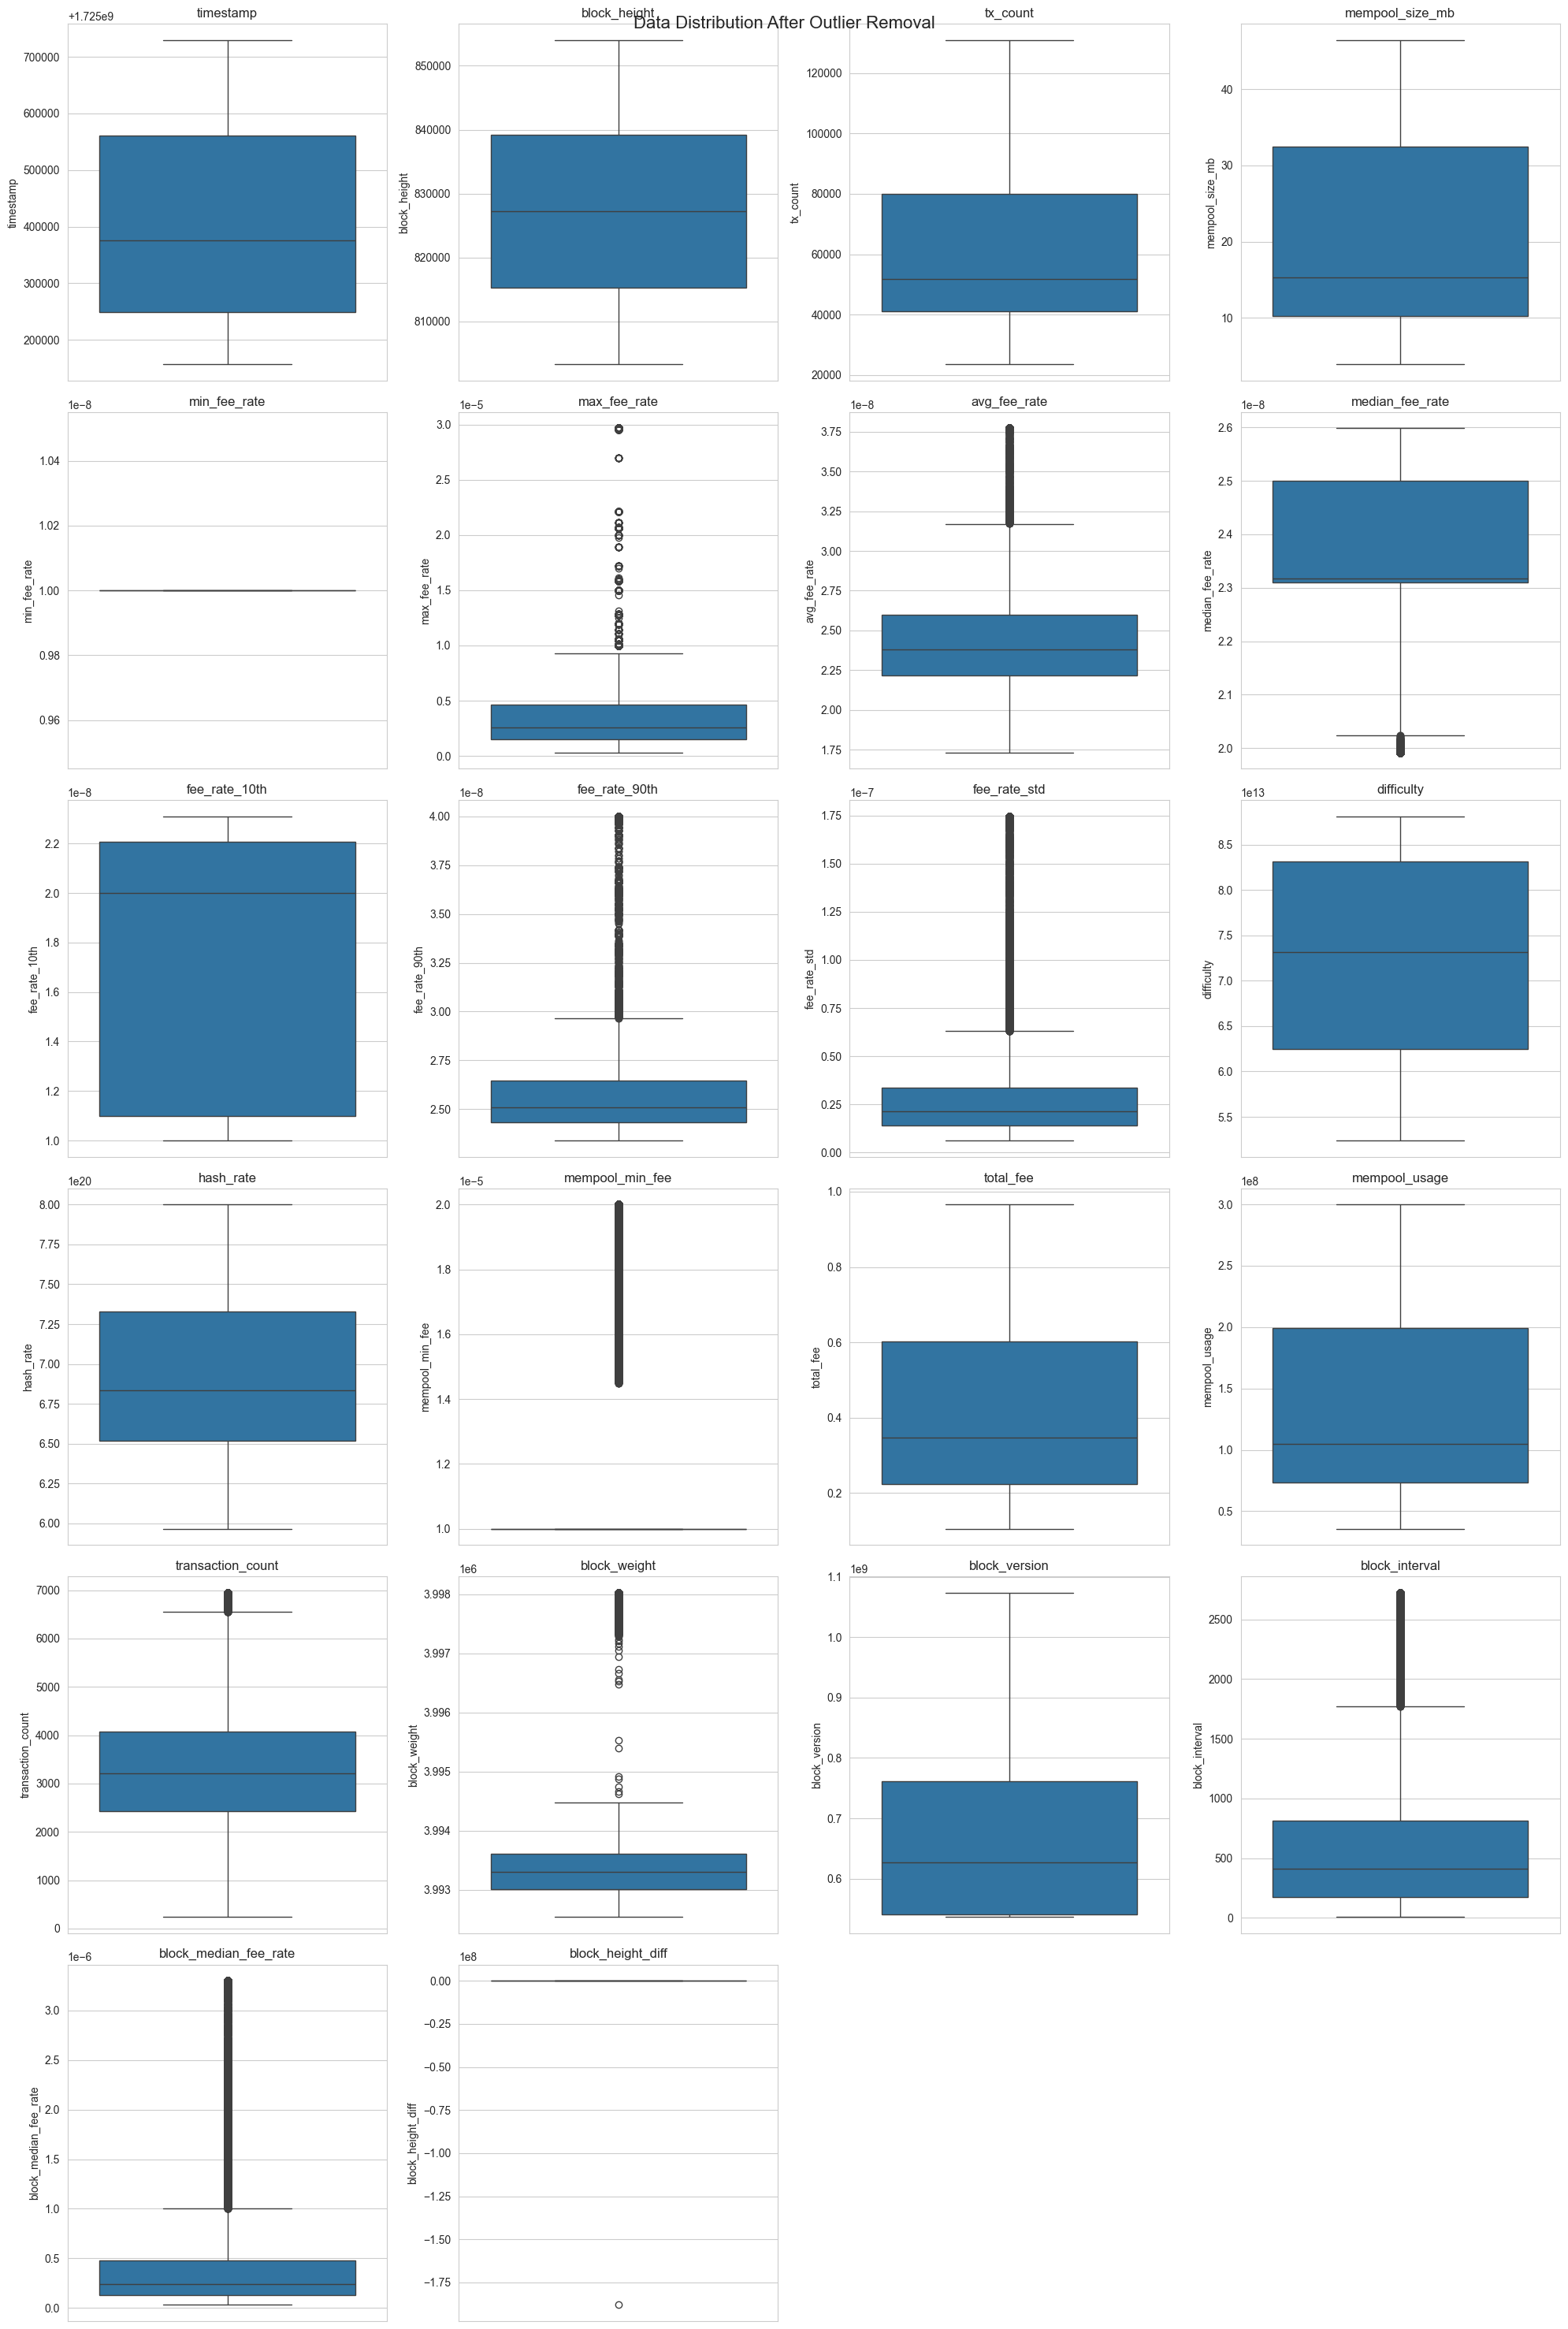

In [214]:
# Define a function to remove outliers by clipping based on percentiles
def handle_outliers(data, column, lower_percentile=1, upper_percentile=99):
    lower = np.percentile(data[column], lower_percentile)
    upper = np.percentile(data[column], upper_percentile)
    data[column] = data[column].clip(lower, upper)
    return data

# Remove outliers for all columns except for 'block_height', 'timestamp', and 'difficulty'
for column in df_cleaned.columns:
    if column not in ['block_height', 'timestamp', 'difficulty']:  # Exclude these columns
        df_cleaned = handle_outliers(df_cleaned, column)


plot_boxplots(df_cleaned, "Data Distribution After Outlier Removal")


In [215]:
# Remove 'block_height_diff' and 'min_fee_rate' columns from df_cleaned
df_cleaned = df_cleaned.drop(columns=['block_height_diff', 'min_fee_rate'])

print(df_cleaned.columns)


Index(['timestamp', 'block_height', 'tx_count', 'mempool_size_mb',
       'max_fee_rate', 'avg_fee_rate', 'median_fee_rate', 'fee_rate_10th',
       'fee_rate_90th', 'fee_rate_std', 'difficulty', 'hash_rate',
       'mempool_min_fee', 'total_fee', 'mempool_usage', 'transaction_count',
       'block_weight', 'block_version', 'block_interval',
       'block_median_fee_rate'],
      dtype='object')


In [216]:
df_cleaned.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 47919 entries, 2023-08-15 13:04:26 to 2024-06-30 11:25:16
Data columns (total 20 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   timestamp              47919 non-null  int64  
 1   block_height           47919 non-null  int64  
 2   tx_count               47919 non-null  float64
 3   mempool_size_mb        47919 non-null  float64
 4   max_fee_rate           47919 non-null  float64
 5   avg_fee_rate           47919 non-null  float64
 6   median_fee_rate        47919 non-null  float64
 7   fee_rate_10th          47919 non-null  float64
 8   fee_rate_90th          47919 non-null  float64
 9   fee_rate_std           47919 non-null  float64
 10  difficulty             47919 non-null  float64
 11  hash_rate              47919 non-null  float64
 12  mempool_min_fee        47919 non-null  float64
 13  total_fee              47919 non-null  float64
 14  mempool_usage      

In [217]:
print("\nSummary statistics of raw data:")
print(df.describe())

print("\nSummary statistics of cleaned data:")
print(df_cleaned.describe())

df_cleaned.to_csv('bitcoin_data_cleaned.csv')
print("Cleaned data saved to 'bitcoin_data_cleaned.csv'")



Summary statistics of raw data:
          timestamp  block_height       tx_count  mempool_size_mb  \
count  4.793300e+04  4.793300e+04   47933.000000     4.793300e+04   
mean   1.725341e+09  8.315433e+05   64789.984082     1.045537e+02   
std    1.114655e+07  8.591298e+05   32241.747510     1.823757e+04   
min    0.000000e+00  0.000000e+00       0.000000     0.000000e+00   
25%    1.725248e+09  8.152810e+05   40993.000000     1.024717e+01   
50%    1.725376e+09  8.272640e+05   51790.000000     1.529292e+01   
75%    1.725560e+09  8.392460e+05   79882.000000     3.250172e+01   
max    1.725729e+09  1.888938e+08  134999.000000     3.992883e+06   

       min_fee_rate  max_fee_rate  avg_fee_rate  median_fee_rate  \
count  4.793300e+04  4.793300e+04  4.793300e+04     4.793300e+04   
mean   1.260713e+04  1.510967e+00  6.877893e-04     3.581211e+04   
std    2.756274e+06  3.278624e+02  1.505766e-01     7.840563e+06   
min    1.000000e-08  2.507937e-08  1.592778e-08     1.000000e-08   
25%  

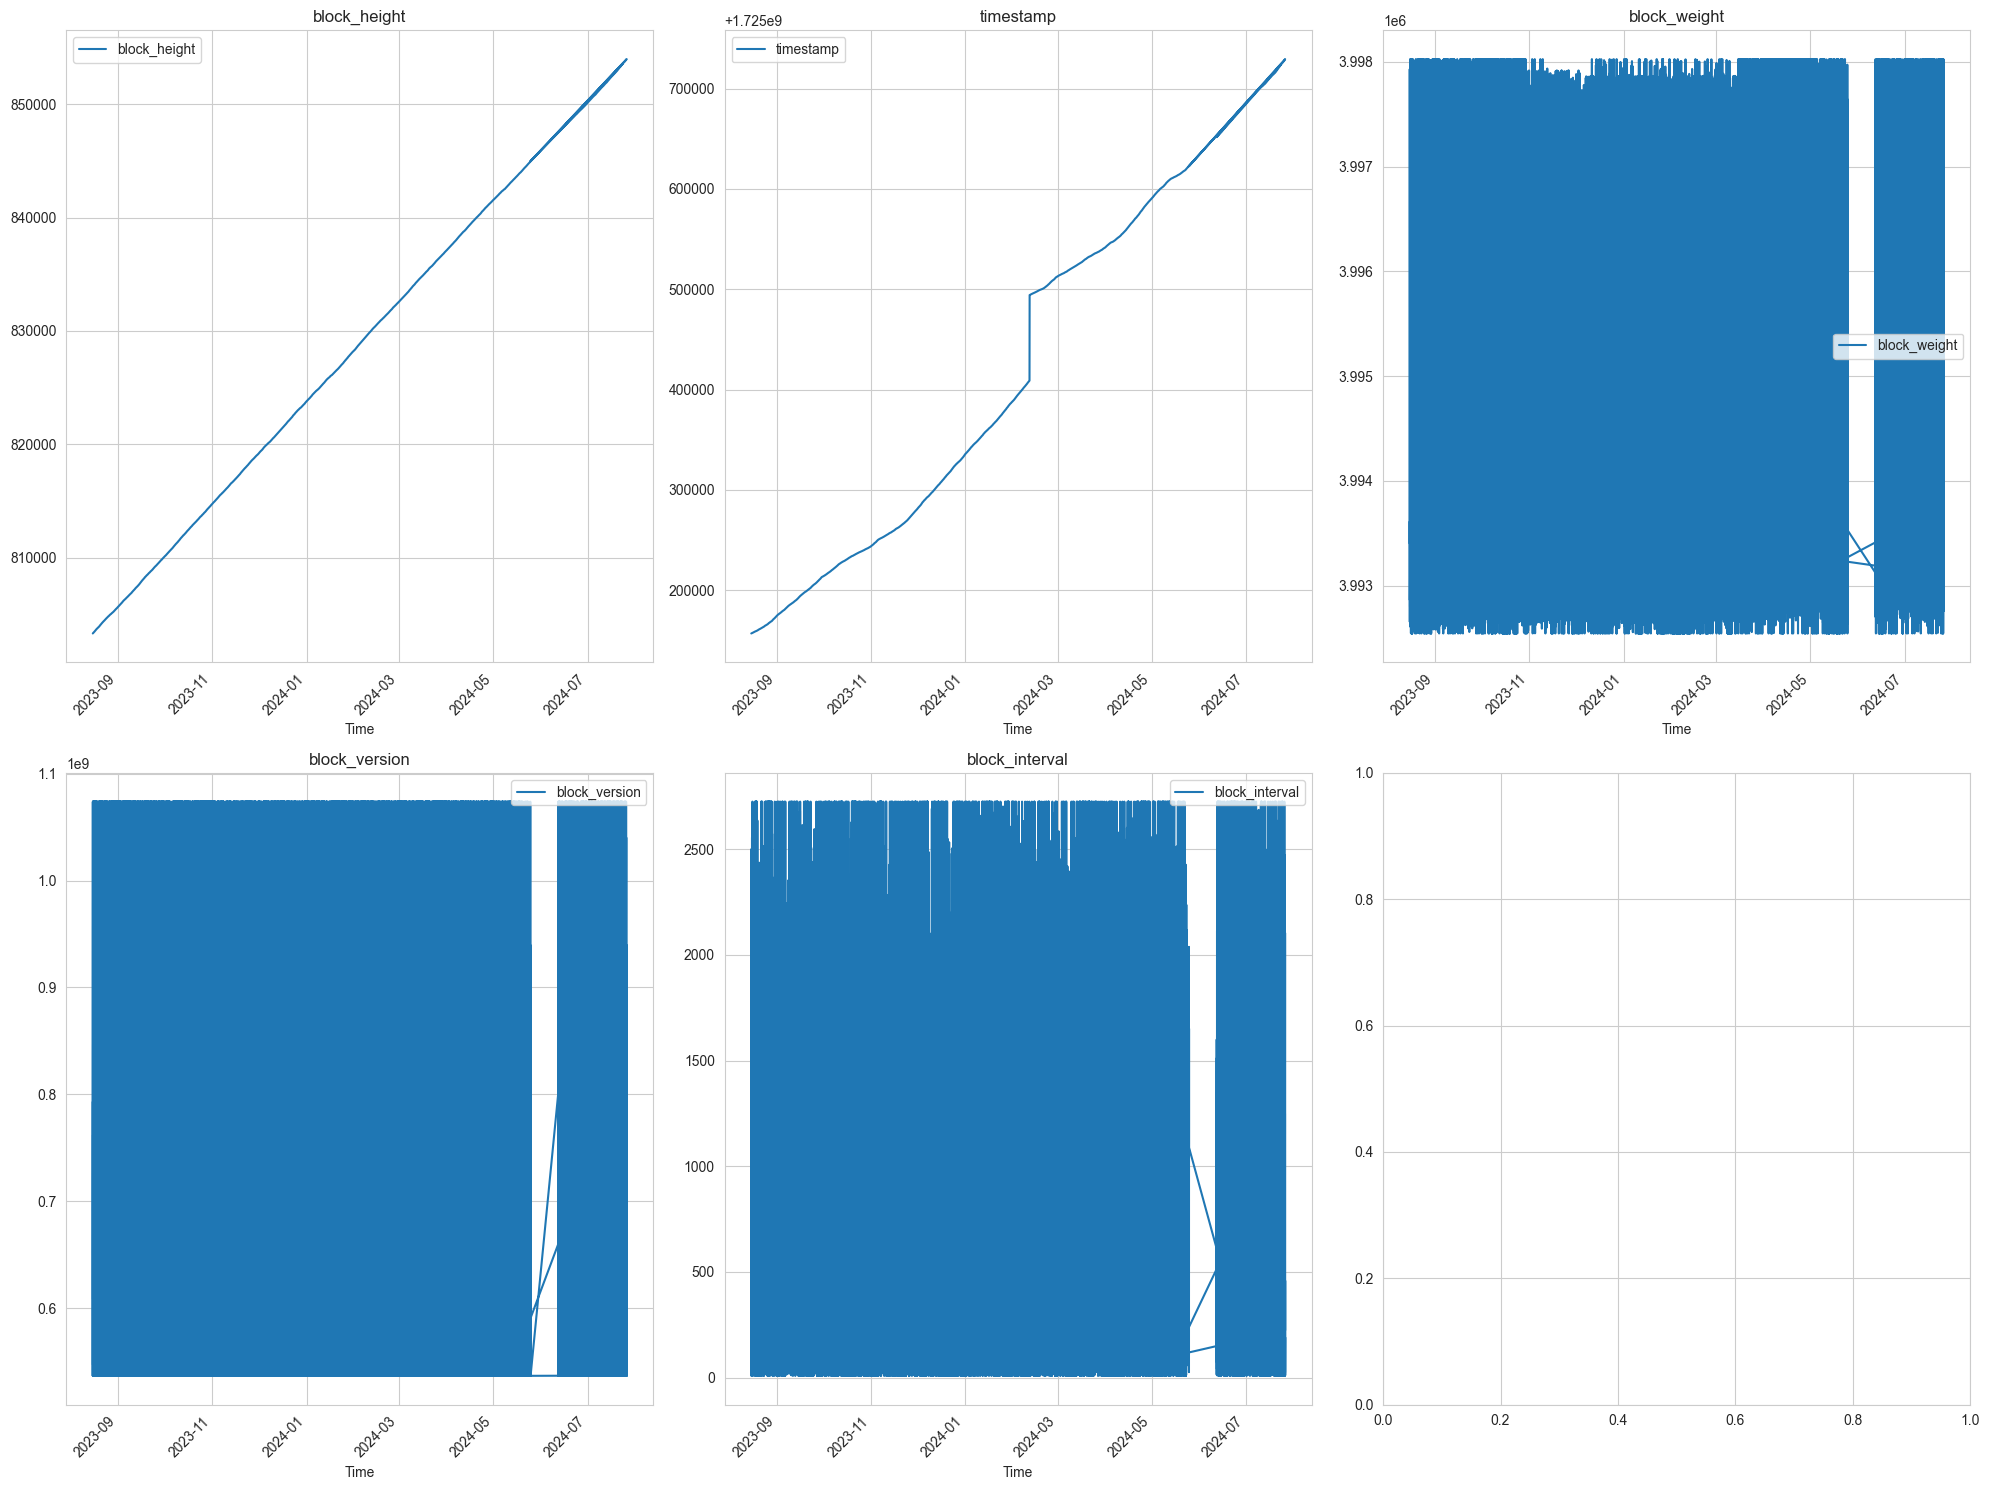

In [218]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

def plot_time_series(df, features, rows=3, cols=3, figsize=(20, 15)):
    fig, axes = plt.subplots(rows, cols, figsize=figsize)
    axes = axes.flatten() 
    
    for i, feature in enumerate(features):
        if i < len(axes) and feature in df.columns:
            ax = axes[i]
            df.plot(y=feature, ax=ax)
            ax.set_title(feature)
            ax.set_xlabel('Time')
            ax.tick_params(axis='x', rotation=45)
    
    plt.tight_layout()
    plt.show()

# Update these lists based on the columns actually present in df_cleaned
block_features = ['block_height', 'timestamp', 'block_weight', 'block_version', 'block_interval']
transaction_features = ['tx_count', 'transaction_count', 'total_fee']
fee_features = ['min_fee_rate', 'max_fee_rate', 'avg_fee_rate', 'median_fee_rate', 'fee_rate_10th', 'fee_rate_90th', 'fee_rate_std', 'block_median_fee_rate']
mempool_features = ['mempool_size_mb', 'mempool_min_fee', 'mempool_usage']
network_features = ['difficulty', 'hash_rate']


plot_time_series(df_cleaned, block_features,rows=2, cols=3)



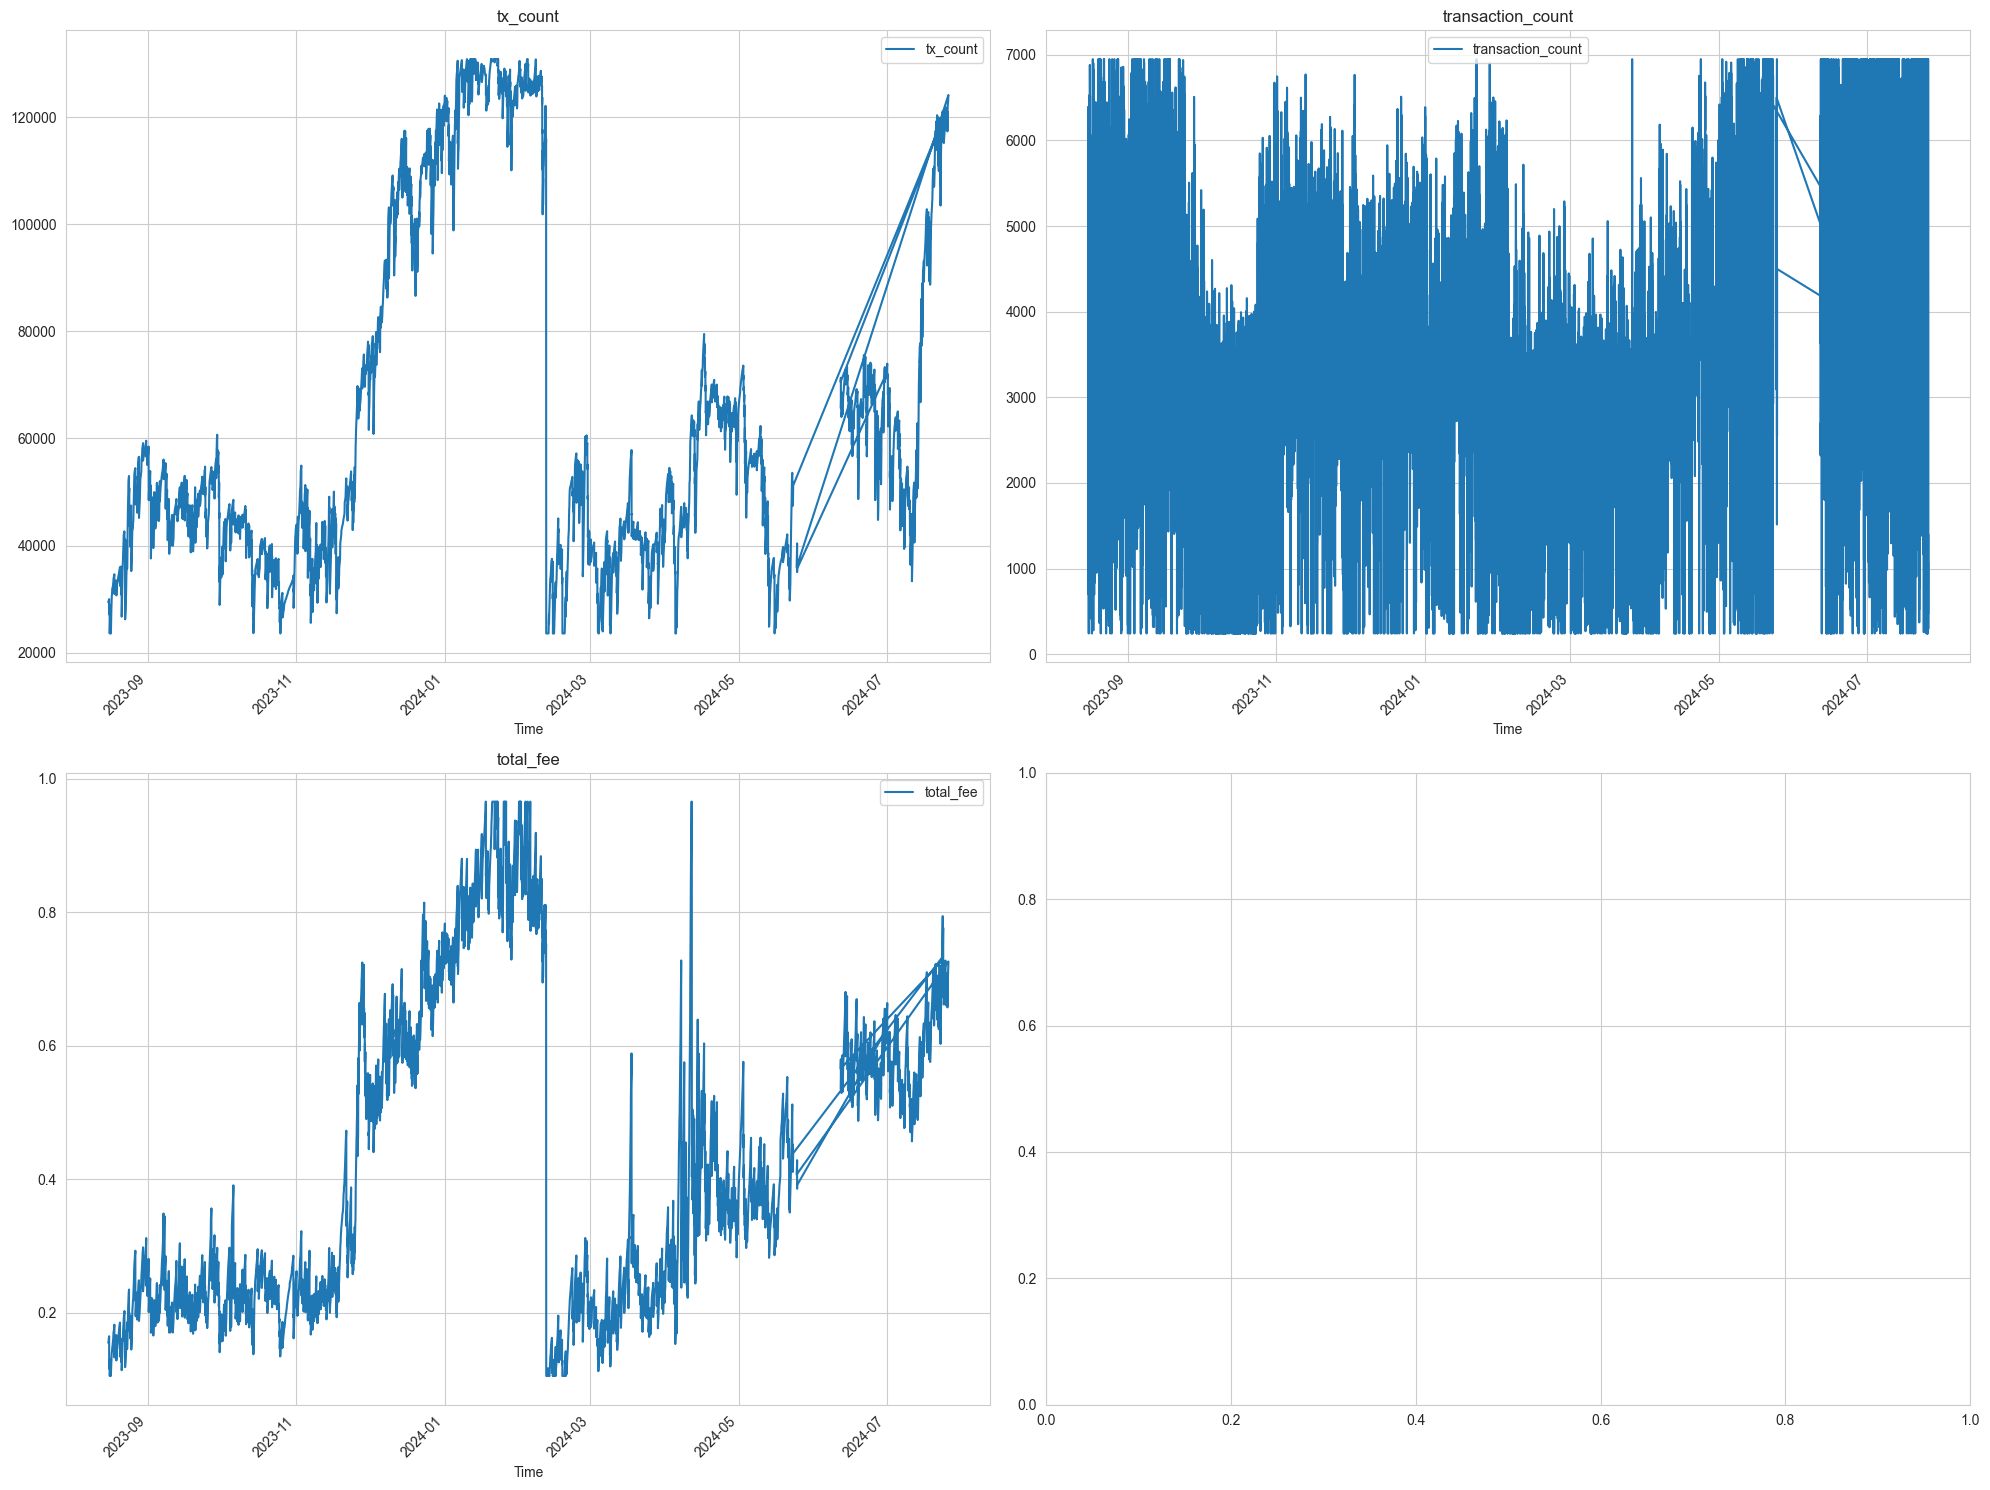

In [219]:
plot_time_series(df_cleaned, transaction_features,rows=2, cols=2)

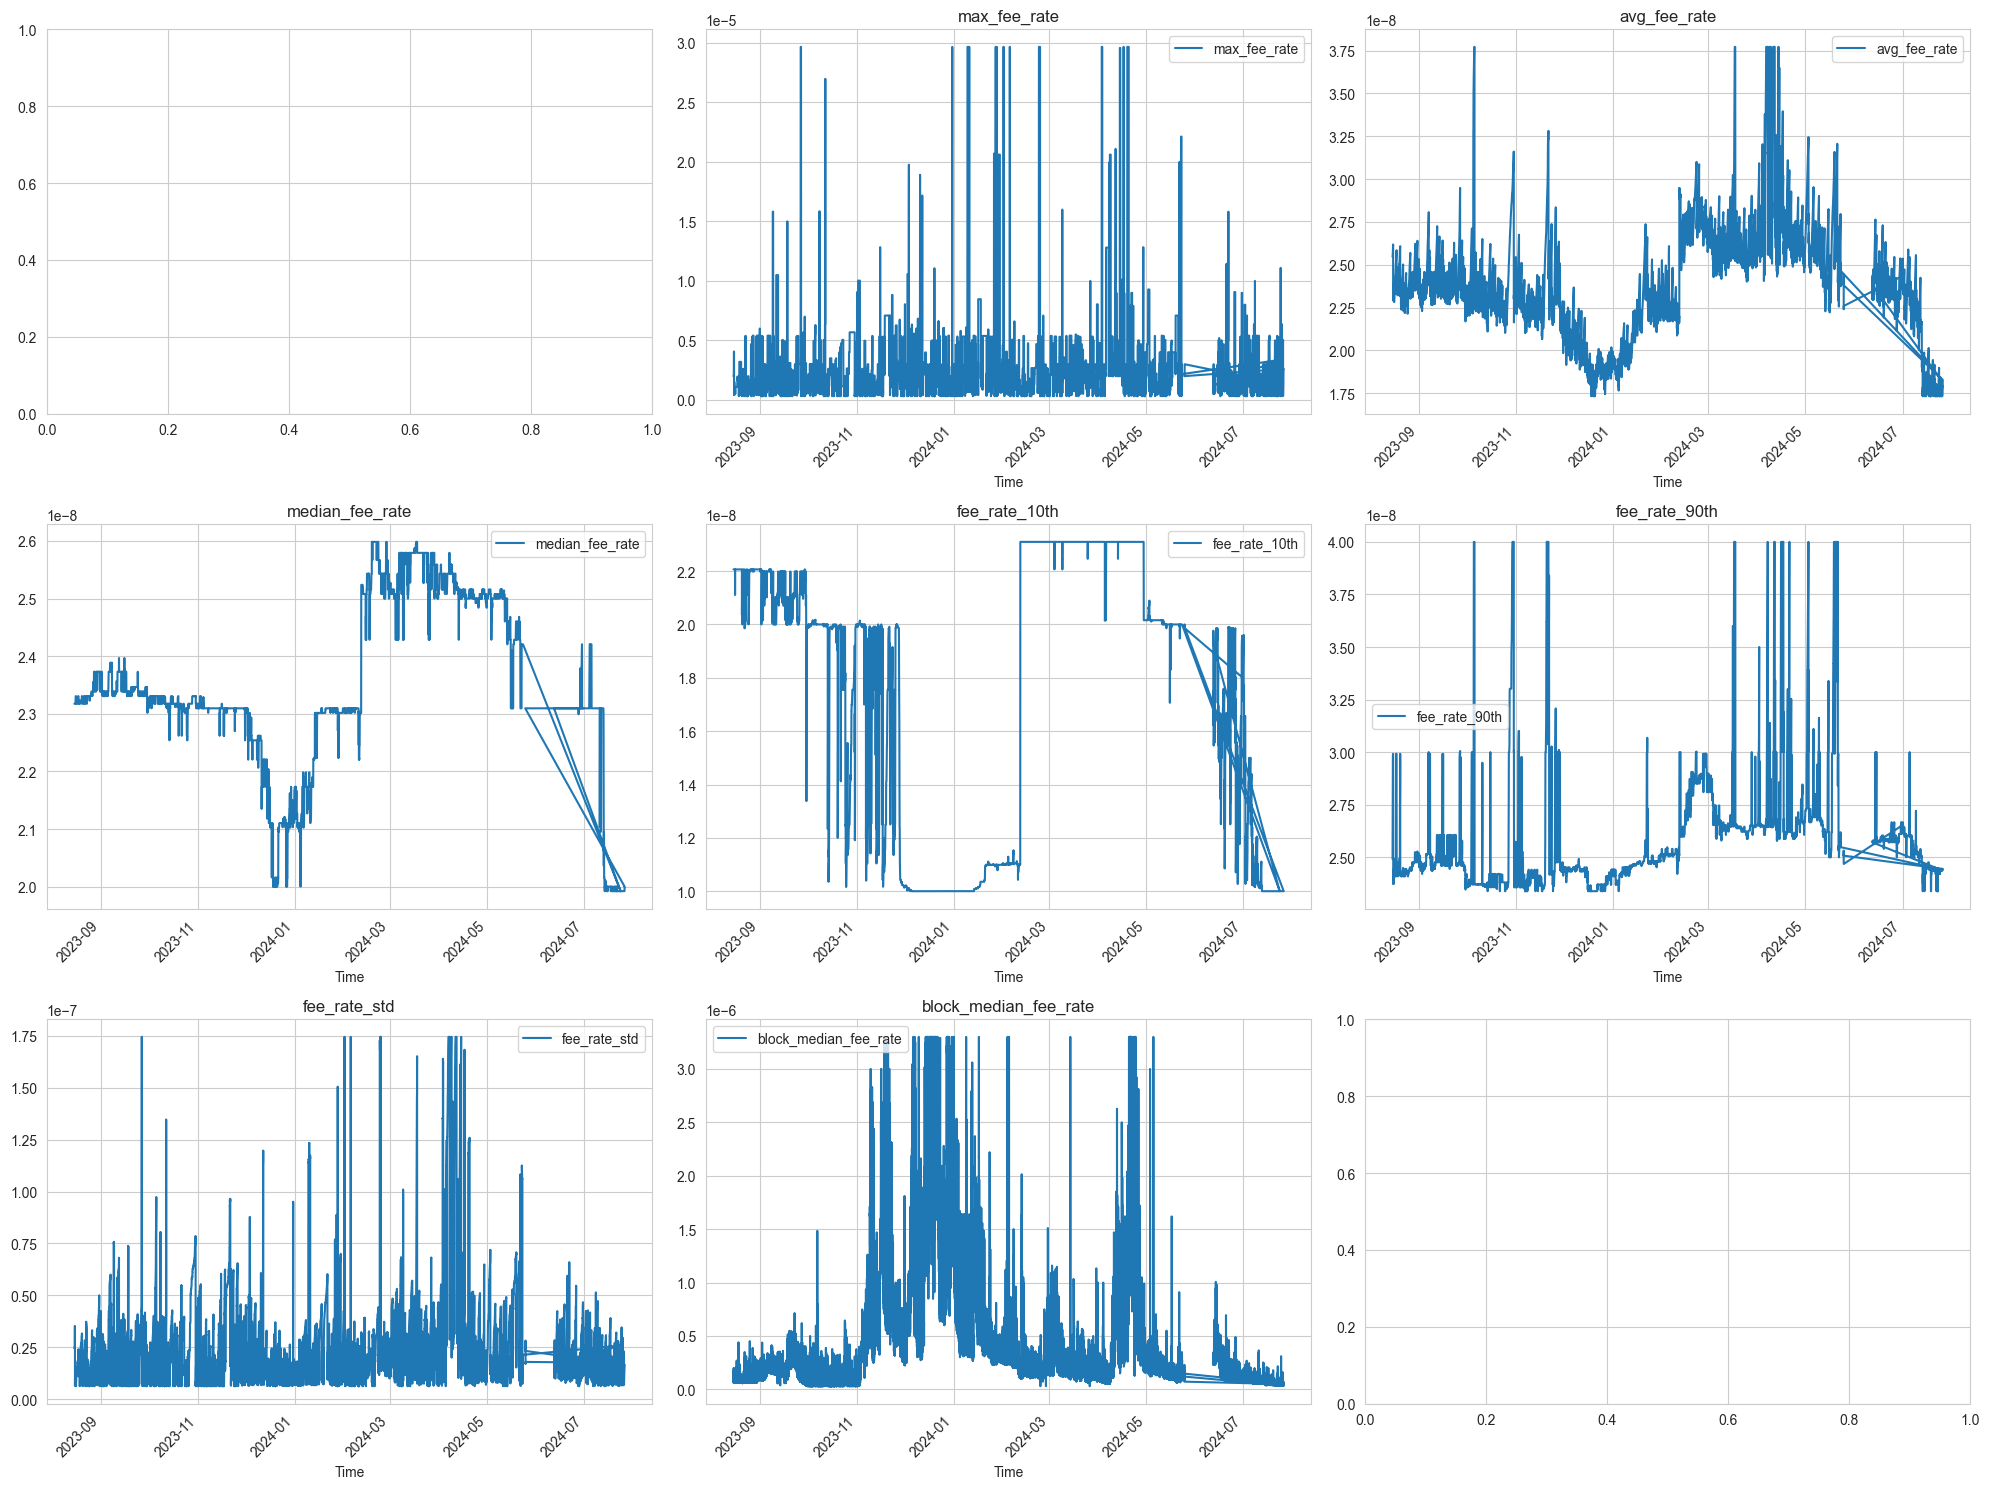

In [220]:

plot_time_series(df_cleaned, fee_features)



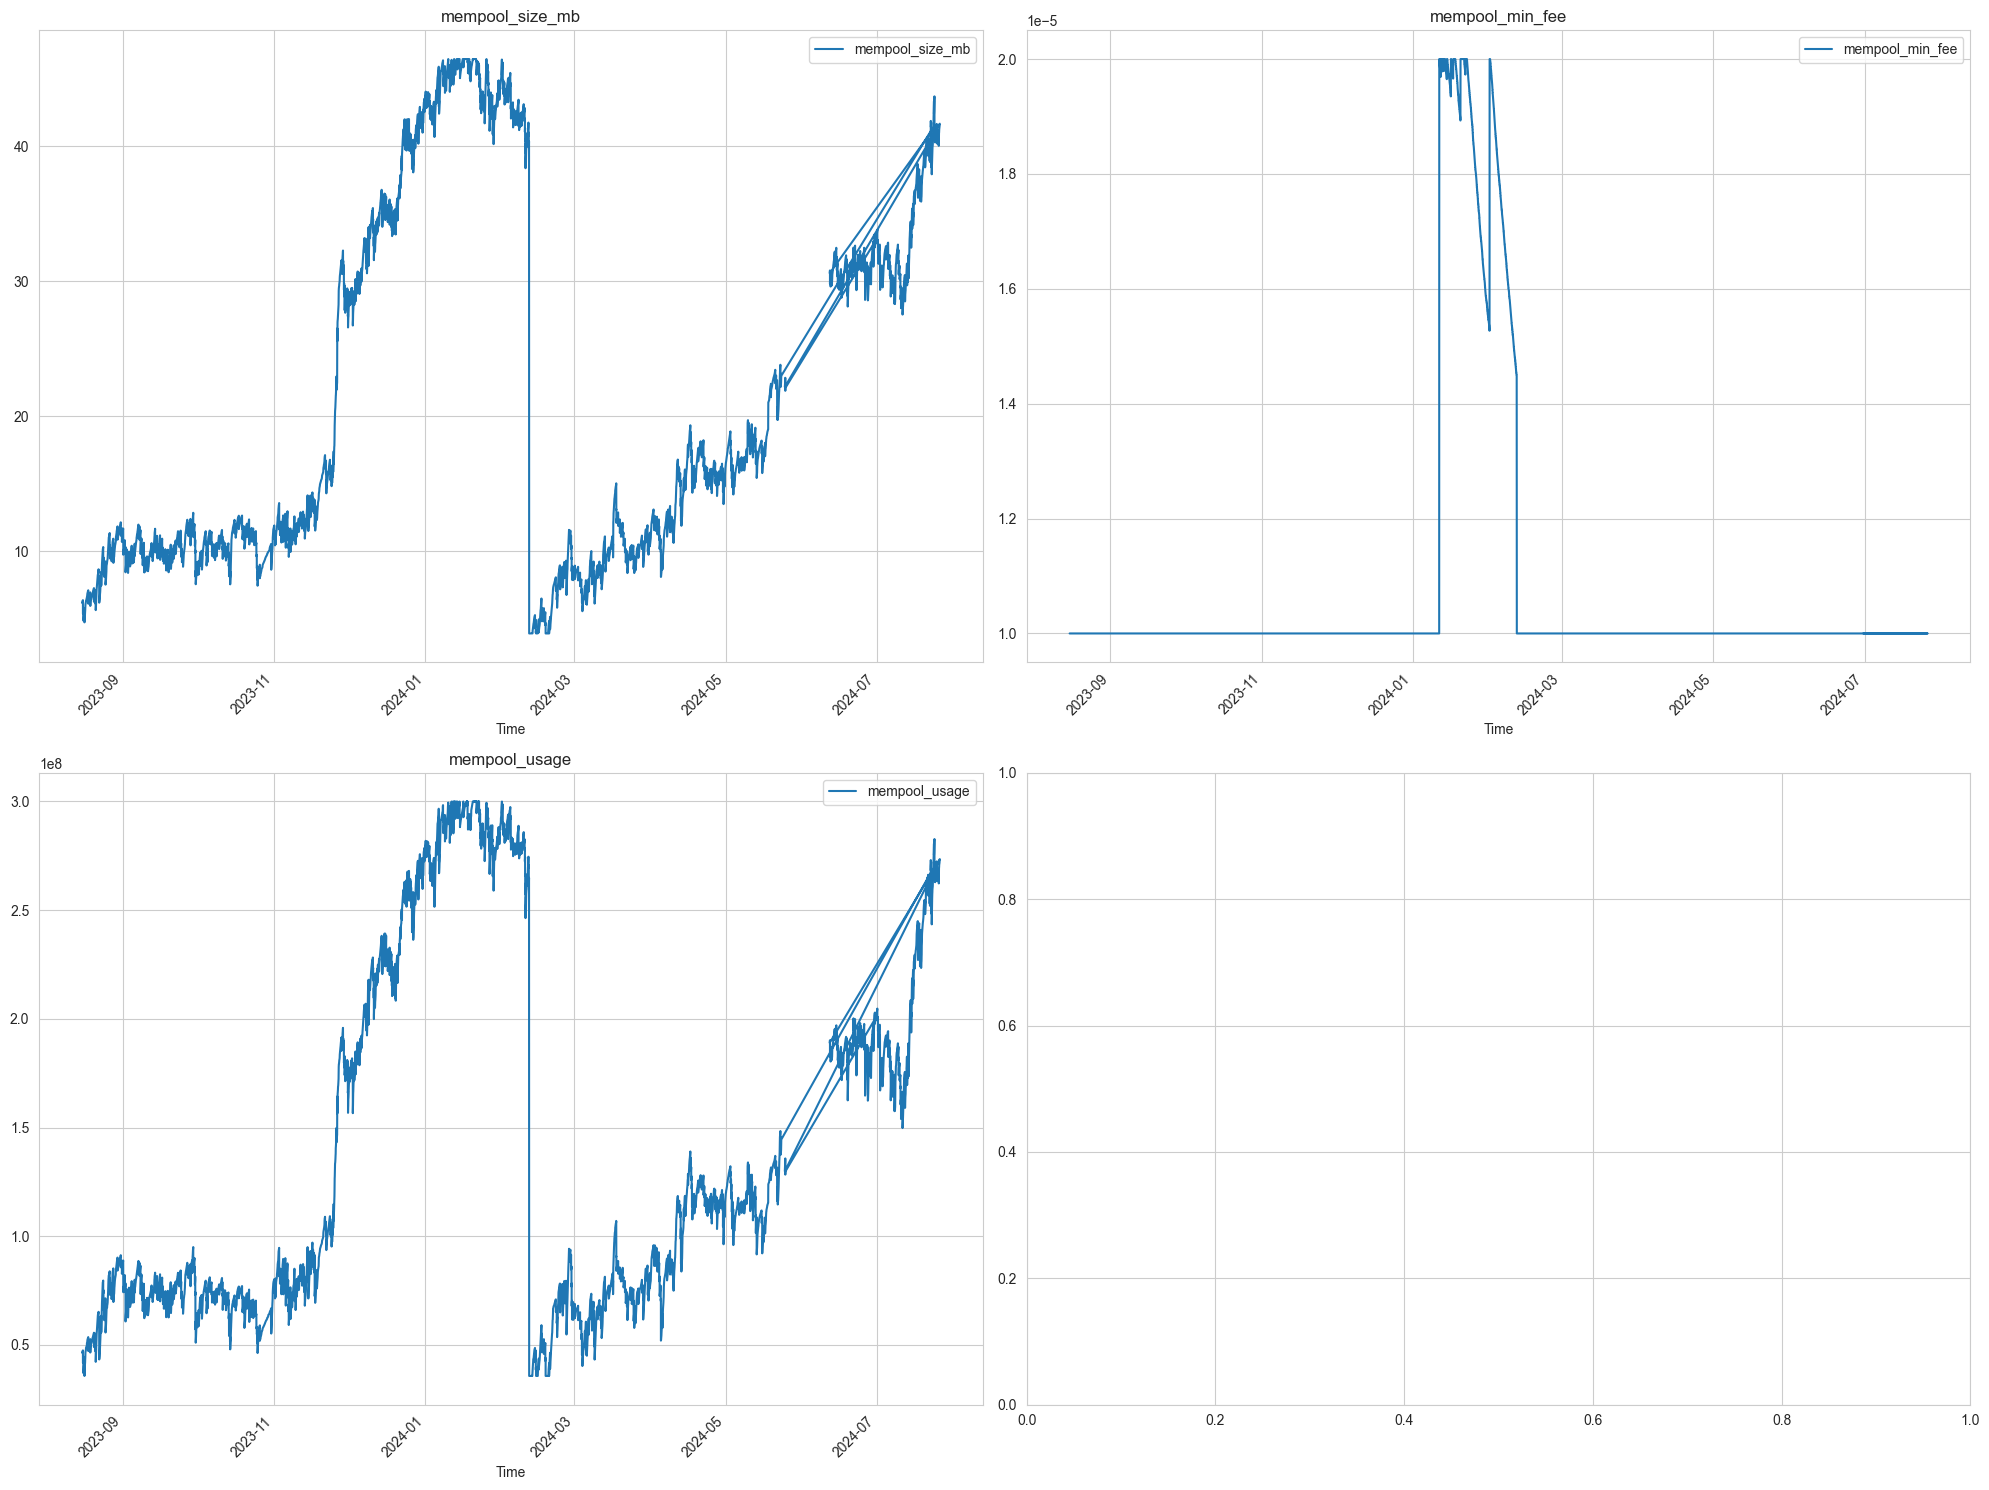

In [221]:
plot_time_series(df_cleaned, mempool_features,rows=2,cols=2)


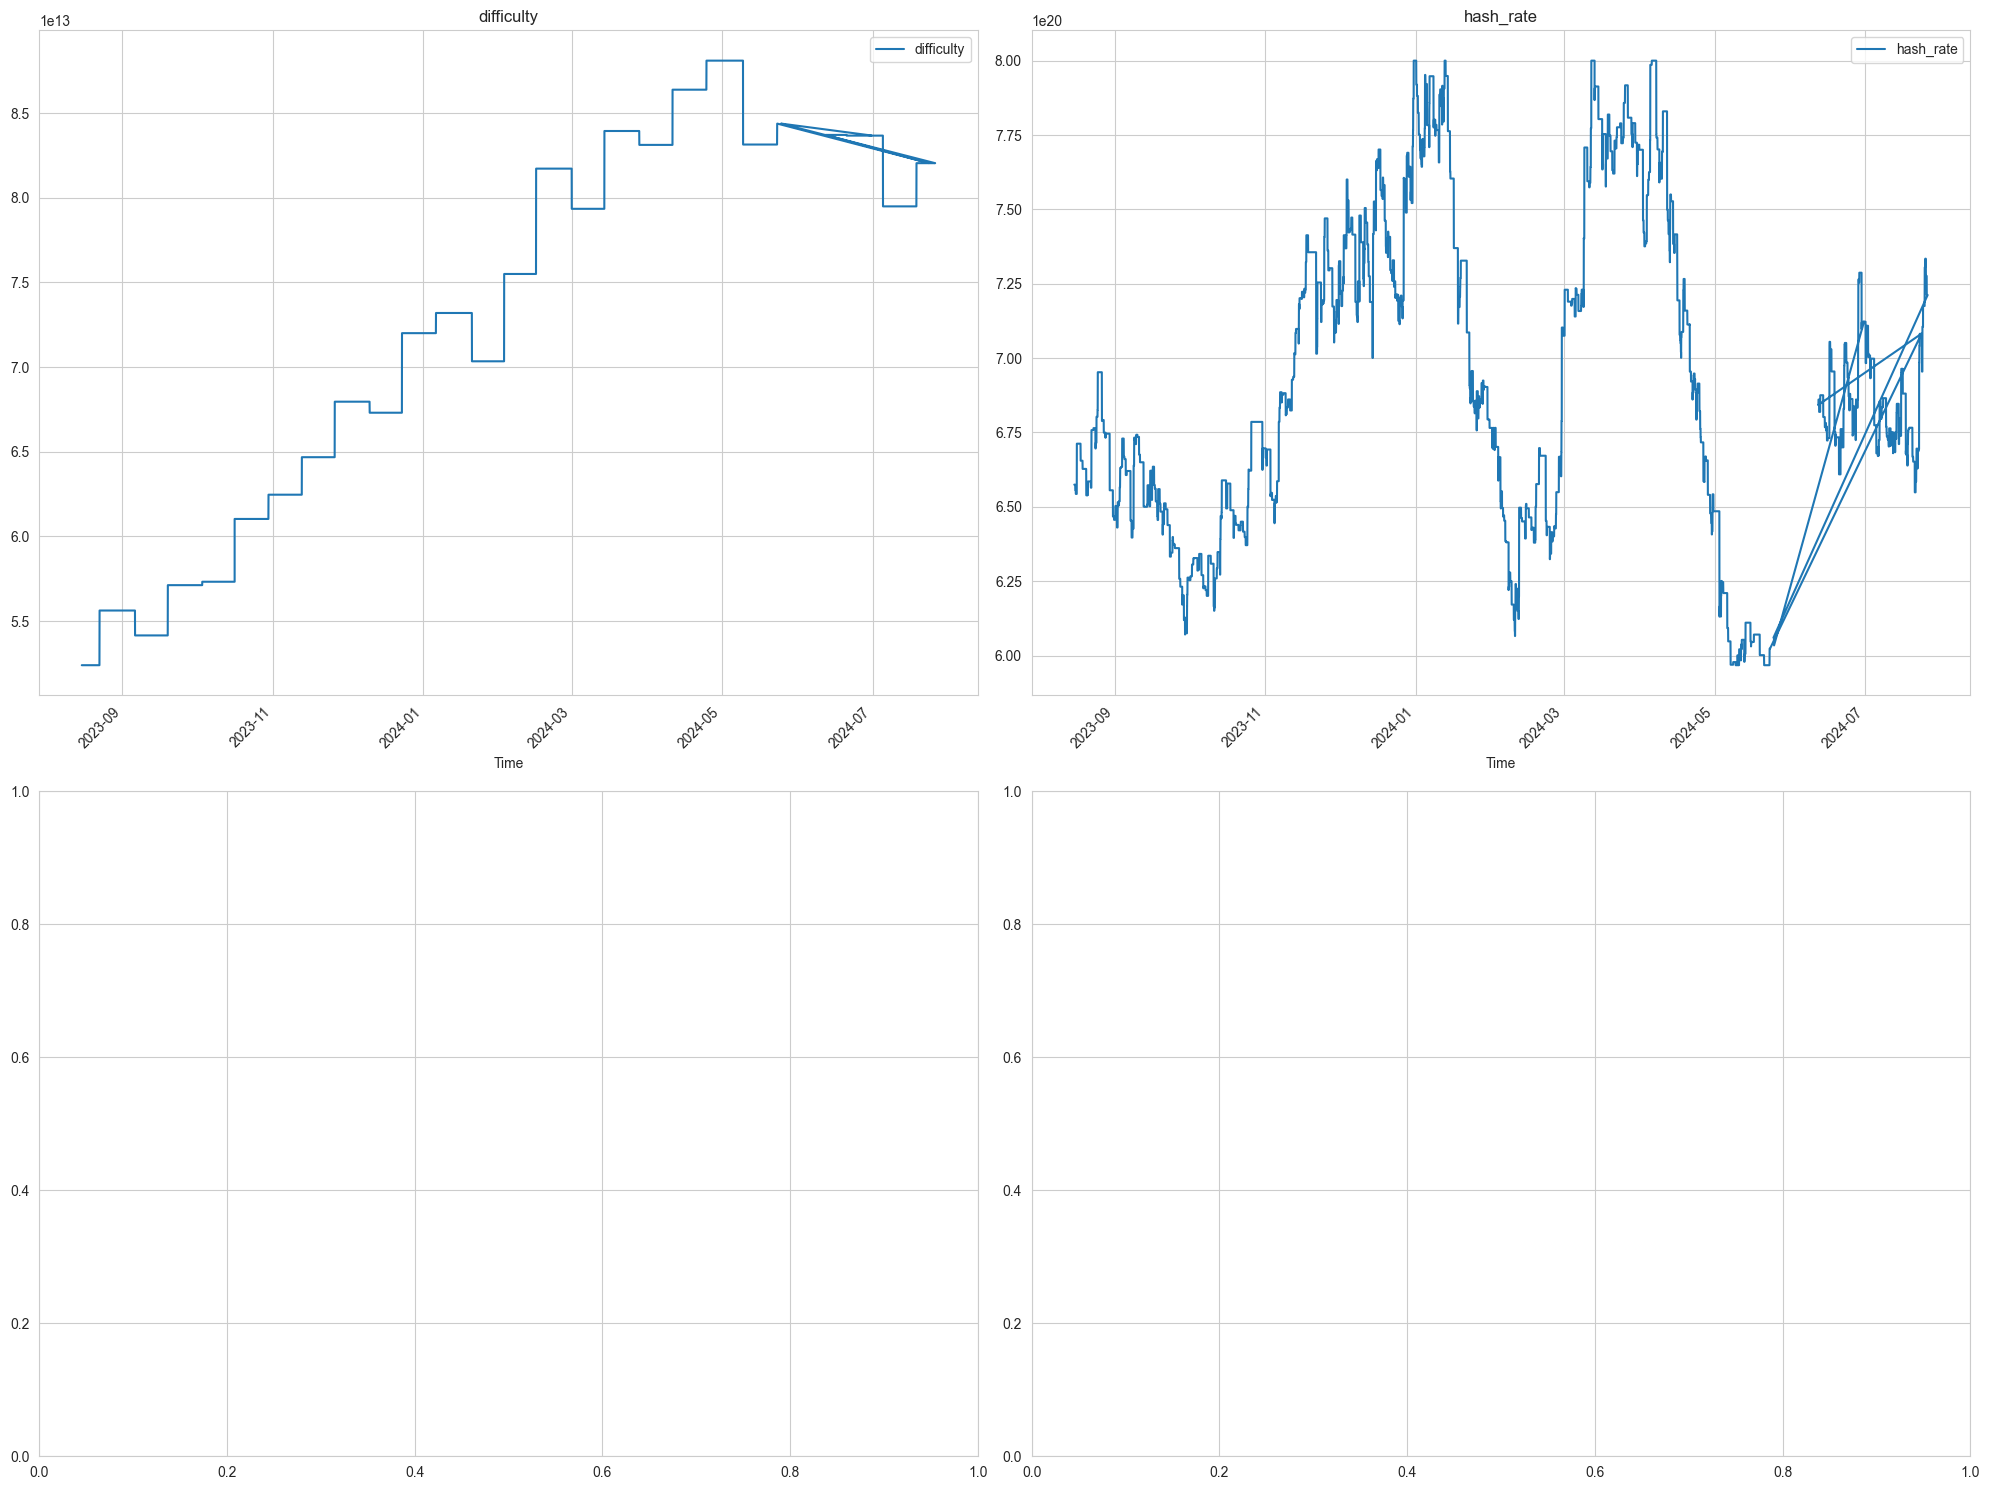

In [222]:
plot_time_series(df_cleaned, network_features,rows=2,cols=2)

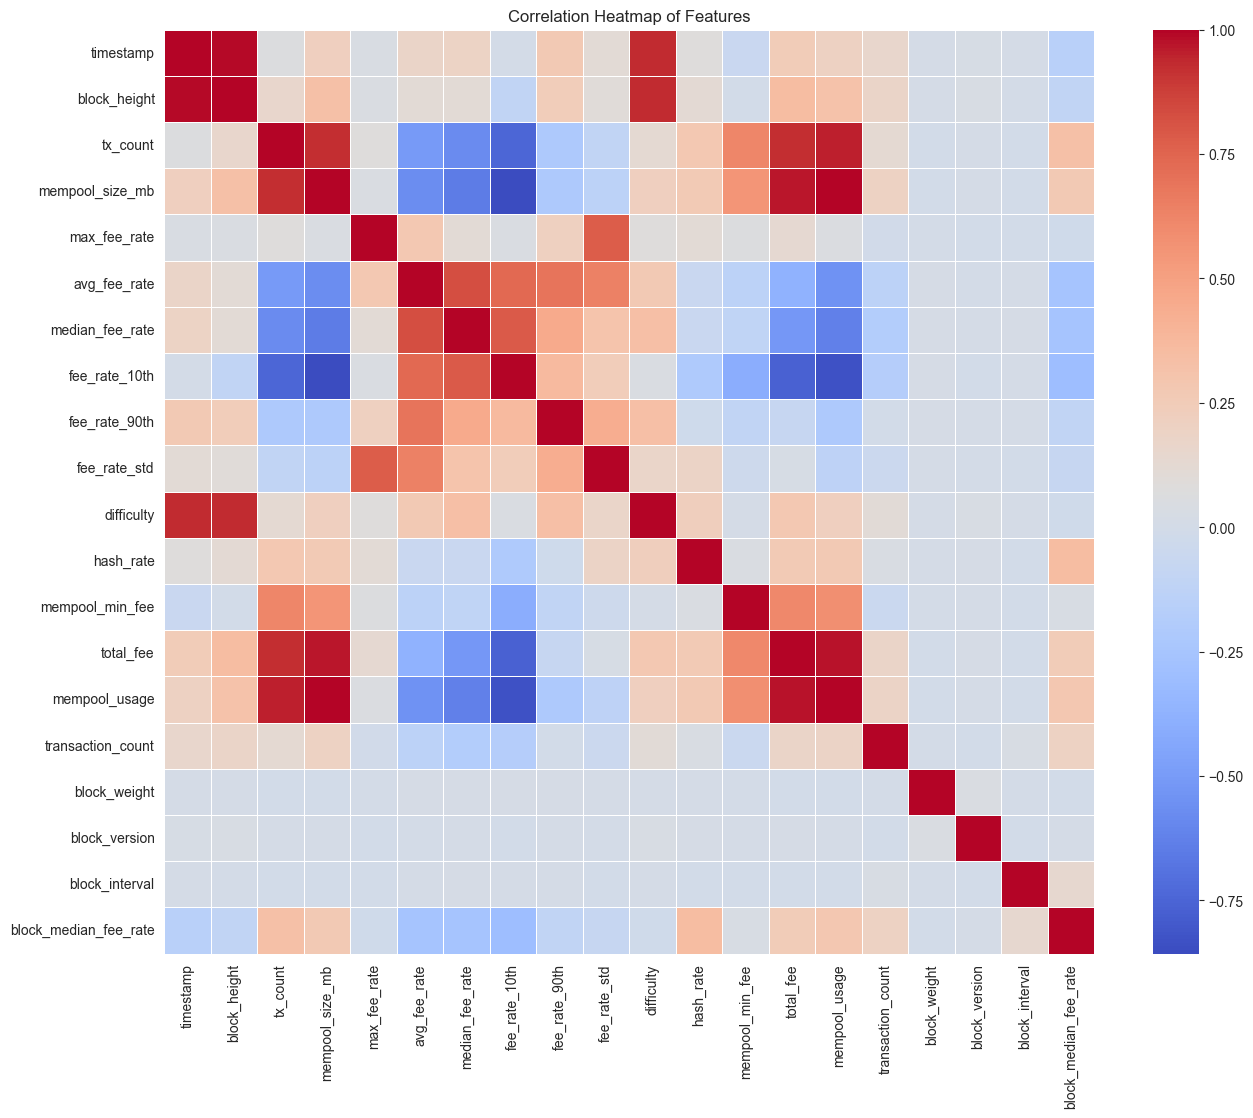

In [223]:
# Correlation heatmap
plt.figure(figsize=(15, 12))
sns.heatmap(df_cleaned.corr(), annot=False, cmap='coolwarm', linewidths=0.5)
plt.title('Correlation Heatmap of Features')
plt.show()

Next Steps Based on the Heatmap:
Feature Selection:

You can use this heatmap to identify redundant features that might not provide additional value. For instance, if two features are highly correlated (e.g., block_height and timestamp), you might choose to keep only one of them to avoid multicollinearity in some models (like linear regression).
Further Analysis:

Features with weak correlations could be studied further to see how they interact with the target variable or with other features.
Data Preprocessing:

If you plan to use algorithms sensitive to correlated features (like linear models), you might consider techniques like Principal Component Analysis (PCA) or simply drop one of the highly correlated features.

Feature selection for time series and random forest models:

For Time Series Models:

Keep time-dependent features (like timestamp).
Consider creating lag features or rolling statistics.
Remove highly correlated features, but be careful not to remove features that carry important temporal information.

For Random Forest Models:

Random Forests can handle correlated features better than linear models.
However, removing some highly correlated features can still improve model interpretability and potentially performance.
Consider using feature importance scores from the Random Forest to guide feature selection.